## Предсказание пола/возраста по посещениям сайтов

Для начала, подключим хранилище s3, содержащее исходные данные:

In [1]:
!chmod 600 .s3_passwd
!mkdir -p mnt
!s3fs hsevkhack mnt -o url=http://hb.vkcs.cloud -o use_path_request_style -o passwd_file=.s3_passwd -o ro

chmod: cannot access '.s3_passwd': No such file or directory
/bin/bash: line 1: s3fs: command not found


Убедимся, что в директории `mnt` содержатся соответствующие таблицы:

In [ ]:
!ls mnt/

Если по каким-то причинам директорию смонтировать не удалось, используйте код ниже, чтобы скачать данные к себе в локальное хранилище. В противном случае **пропустите следующую ячейку**.

In [ ]:
import subprocess
!mkdir -p data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv -P data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv -P data
!mkdir -p data/requests
for i in range(30):
    print(f"Downloading part {i}...")
    subprocess.call(["wget", f"https://hsehack.hb.ru-msk.vkcs.cloud/requests/part_{i}.parquet", "-q", "-P", "data/requests"])

--2024-04-21 06:54:05--  https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63042 (62K) [text/csv]
Saving to: ‘data/geo_dataframe.csv’

geo_dataframe.csv   100%[===================>]  61.56K   398KB/s    in 0.2s    

2024-04-21 06:54:07 (398 KB/s) - ‘data/geo_dataframe.csv’ saved [63042/63042]

--2024-04-21 06:54:07--  https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66826127 (64M) [text/csv]
Saving to: ‘data/train_users.csv’

train_users.csv     100%[===================>]  63.73M  18.0MB/

## Загружаем данные

Используем Pandas для работы с таблицами. `geo_dataframe` содержит данные о геолокации - регионе и стране.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import datetime

In [ ]:
geo = pd.read_csv('mnt/geo_dataframe.csv')
geo

,geo_id,region_id,country_id
0,1,157,40
1,2,161,40
2,3,265,54
3,4,122,54
4,5,78,40
...,...,...,...
5528,5529,246,54
5529,5530,-1,63
5530,5531,101,40
5531,5532,21,68


In [ ]:
geo.drop('region_id', axis=1, inplace=True)

In [ ]:
geo

,geo_id,country_id
0,1,40
1,2,40
2,3,54
3,4,54
4,5,40
...,...,...
5528,5529,54
5529,5530,63
5530,5531,40
5531,5532,68


Таблица `train_users` - это ваша обучающая выборка, содержащая пол и возраст пользователей. Аналогичная таблица для тестового датасета будет вам предоставлена за час до stop coding.

In [ ]:
users = pd.read_csv('mnt/train_users.csv')
users

,user_id,gender,age
0,2,1,61
1,3,1,55
2,6,0,46
3,14,0,66
4,17,0,53
...,...,...,...
4999995,17588859,1,64
4999996,17588860,0,69
4999997,17588861,1,51
4999998,17588864,0,30


Для примера - вот распределение пользователей по полу:

<Axes: xlabel='gender'>

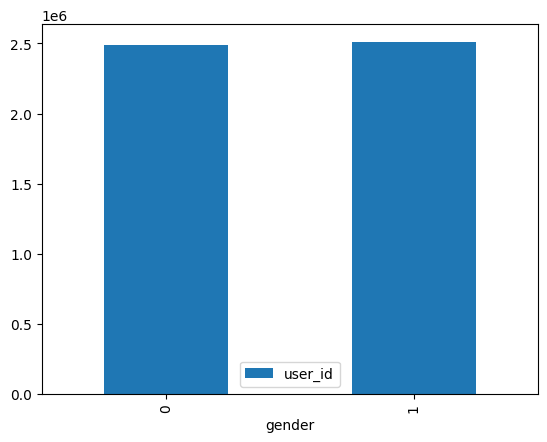

In [ ]:
users.groupby('gender').agg({ 'user_id' : len }).plot.bar()

Основные данные о посещениях пользователями сайтов содержатся в табличке `requests`, представленной в формате parquet. Вы можете загрузить только одну часть таблички, или же всю таблицу, если она поместиться в памяти:

In [ ]:
req0 = pd.read_parquet('mnt/requests/part_0.parquet')
req1 = pd.read_parquet('mnt/requests/part_1.parquet')
req2 = pd.read_parquet('mnt/requests/part_2.parquet')
req3 = pd.read_parquet('mnt/requests/part_3.parquet')
req4 = pd.read_parquet('mnt/requests/part_4.parquet')
req5 = pd.read_parquet('mnt/requests/part_5.parquet')
req6 = pd.read_parquet('mnt/requests/part_6.parquet')
req7 = pd.read_parquet('mnt/requests/part_7.parquet')
req8 = pd.read_parquet('mnt/requests/part_8.parquet')
req9 = pd.read_parquet('mnt/requests/part_9.parquet')
req10 = pd.read_parquet('mnt/requests/part_10.parquet')
req11 = pd.read_parquet('mnt/requests/part_11.parquet')
req12 = pd.read_parquet('mnt/requests/part_12.parquet')
req13 = pd.read_parquet('mnt/requests/part_13.parquet')
req14 = pd.read_parquet('mnt/requests/part_14.parquet')
req15 = pd.read_parquet('mnt/requests/part_15.parquet')
req16 = pd.read_parquet('mnt/requests/part_16.parquet')
req17 = pd.read_parquet('mnt/requests/part_17.parquet')
req18 = pd.read_parquet('mnt/requests/part_18.parquet')
req19 = pd.read_parquet('mnt/requests/part_19.parquet')
req20 = pd.read_parquet('mnt/requests/part_20.parquet')
req21 = pd.read_parquet('mnt/requests/part_21.parquet')
req22 = pd.read_parquet('mnt/requests/part_22.parquet')
req23 = pd.read_parquet('mnt/requests/part_23.parquet')
req24 = pd.read_parquet('mnt/requests/part_24.parquet')
req25 = pd.read_parquet('mnt/requests/part_25.parquet')
req26 = pd.read_parquet('mnt/requests/part_26.parquet')
req27 = pd.read_parquet('mnt/requests/part_27.parquet')
req28 = pd.read_parquet('mnt/requests/part_28.parquet')
req29 = pd.read_parquet('mnt/requests/part_29.parquet')

KeyboardInterrupt: 

In [ ]:
req0 = pd.read_parquet('mnt/requests/part_0.parquet')
req0 = req0[req0.index % 2 == 0]
req16 = pd.read_parquet('mnt/requests/part_16.parquet')
req16 = req16[req16.index % 2 == 0]
req21 = pd.read_parquet('mnt/requests/part_21.parquet')
req21 = req21[req21.index % 2 == 0]

In [ ]:
result = pd.concat([req0, req16, req21])


In [ ]:
#merged_df = pd.merge(result, geo, on='geo_id')



In [ ]:
import pandas as pd
test = pd.read_csv('/content/test_users.csv')
y1 = test['age']
y2 = test['gender']
test = test.drop(["age"], axis=1)
test = test.drop(["gender"], axis=1)

In [ ]:
import pandas as pd
test = pd.read_csv('/content/test_users.csv')
y1 = test['age']
y2 = test['gender']
test = test.drop(["age"], axis=1)
test = test.drop(["gender"], axis=1)
merged_df = pd.merge(test, result[['user_id', 'age']], on='user_id')


from sklearn.metrics import mean_absolute_error


mae = mean_absolute_error(y2, test['age'])

print(f'MAE: {mae:.2f}')


KeyError: "['age'] not in index"

In [ ]:
merged_df_f = pd.merge(merged_df, users, on='user_id')

In [ ]:
merged_df_f

,timestamp,geo_id,referer,user_id,user_agent,country_id,gender,age
0,1712123586,1224,https://domain_34/path_172133,8521714,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,40,0,66
1,1711969393,1224,https://domain_2715/path_57698,13642195,Mozilla/5.0 (Linux; U; Android 13; ru-ru; POCO...,40,1,38
2,1712003829,1224,https://domain_662/path_167213,10203374,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,40,1,54
3,1711999441,1224,https://domain_2194/path_162789,1412437,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,40,1,75
4,1712111612,1224,https://domain_698/path_91445,16974107,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,40,1,48
...,...,...,...,...,...,...,...,...
2797219,1712005567,714,https://domain_3191/path_22393,17097701,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3 like M...,68,1,50
2797220,1712103986,2891,https://domain_2238/path_74452,1675707,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,32,1,67
2797221,1712029537,3071,https://domain_1718/path_181532,12433669,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,68,1,36
2797222,1711937743,4840,,2198292,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,41,1,61


In [ ]:
merged_df_f = merged_df_f.drop(["referer"], axis=1)
merged_df_f = merged_df_f.drop(["user_id"], axis=1)
merged_df_f

,timestamp,geo_id,user_agent,country_id,gender,age
0,1711987643,1224,Mozilla/5.0 (Linux; arm_64; Android 13; ZS676K...,40,1,68
1,1712040691,1224,Mozilla/5.0 (Linux; arm_64; Android 14; SM-X70...,40,1,68
2,1711968116,1224,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,40,1,68
3,1712075447,1224,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,40,1,68
4,1711971200,1224,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,40,1,68
...,...,...,...,...,...,...
6992419,1712165876,5473,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,31,1,35
6992420,1712114165,5425,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,40,0,35
6992421,1711921029,1467,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,68,0,75
6992422,1711994611,4421,Mozilla/5.0 (Linux; arm_64; Android 9; SM-G892...,54,0,25


In [ ]:
for i in range(1, 40):
  print(merged_df_f["user_id"][i], merged_df_f["user_agent"][i])

KeyError: 'user_id'

In [ ]:
def categorize_user_agent(user_agent):
    if "Android" in user_agent:
        return 2
    elif "Windows" in user_agent:
        return 4
    elif "iOS" in user_agent:
        return 1
    elif "Linux" in user_agent:
        return 3
    else:
        return 5

merged_df_f["user_agent"] = merged_df_f["user_agent"].apply(categorize_user_agent)

def categorize_timestamp(timestamp):
    converted_time = datetime.datetime.utcfromtimestamp(timestamp)
    return int(converted_time.strftime('%H'))

merged_df_f["timestamp"] = merged_df_f["timestamp"].apply(categorize_timestamp)

<Axes: xlabel='user_agent'>

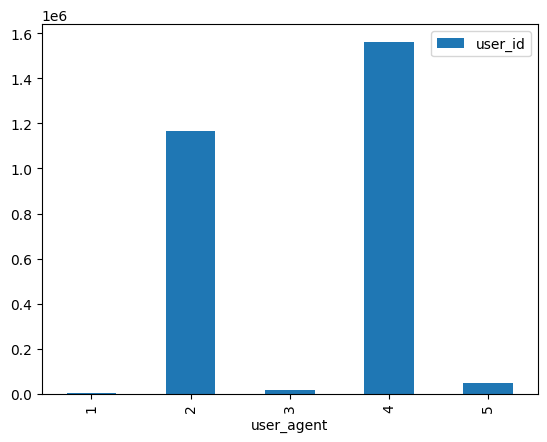

In [ ]:
merged_df_f.groupby('user_agent').agg({ 'user_id' : len }).plot.bar()

In [ ]:
Yage = merged_df_f["age"]

In [ ]:
y = merged_df_f["gender"]
#X = merged_df_f.drop(["gender"], axis=1)
X = merged_df_f.drop("age", axis=1)

In [ ]:
req10 = pd.read_parquet('mnt/requests/part_3.parquet')
req10 = req10[req10.index % 2 == 0]
req12 = pd.read_parquet('mnt/requests/part_12.parquet')
req12 = req12[req12.index % 2 == 0]
req22 = pd.read_parquet('mnt/requests/part_22.parquet')
req22 = req22[req22.index % 2 == 0]

result2 = pd.concat([req10, req12, req22])
merged_df2 = pd.merge(result2, geo, on='geo_id')
merged_df_f2 = pd.merge(merged_df2, users, on='user_id')
merged_df_f2 = merged_df_f2.drop(["referer"], axis=1)
merged_df_f2 = merged_df_f2.drop(["user_id"], axis=1)

def categorize_user_agent(user_agent):
    if "Android" in user_agent:
        return 2
    elif "Windows" in user_agent:
        return 4
    elif "iOS" in user_agent:
        return 1
    elif "Linux" in user_agent:
        return 3
    else:
        return 5

merged_df_f2["user_agent"] = merged_df_f2["user_agent"].apply(categorize_user_agent)

def categorize_timestamp(timestamp):
    converted_time = datetime.datetime.utcfromtimestamp(timestamp)
    return int(converted_time.strftime('%H'))

merged_df_f2["timestamp"] = merged_df_f2["timestamp"].apply(categorize_timestamp)

Yage2 = merged_df_f2["age"]
y2 = merged_df_f2["gender"]
#X2 = merged_df_f2.drop(["gender"], axis=1)
X2 = merged_df_f2.drop("age", axis=1)

# Логистическая регрессия

Обучение

In [ ]:
model = LogisticRegression()
model.fit(X, y)
y_pred_lr = model.predict(X)

In [ ]:
ac = accuracy_score(y, y_pred_lr)
f1 = f1_score(y, y_pred_lr)
print(f'accuracy = {ac:.2f} F1-score = {f1:.2f}')

accuracy = 0.52 F1-score = 0.68


Тест

In [ ]:
y_pred_lr2 = model.predict(X2)

In [ ]:
ac2 = accuracy_score(y2, y_pred_lr2)
f1 = f1_score(y2, y_pred_lr2)
print(f'accuracy = {ac2:.2f} F1-score = {f1:.2f}')

accuracy = 0.52 F1-score = 0.68


# Деревья

Обучение

In [ ]:
depth=30
clf_tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
clf_tree1.fit(X, y)
y_pred_lr = clf_tree1.predict(X2)

In [ ]:
ac = accuracy_score(y, y_pred_lr)
f1 = f1_score(y2, y_pred_lr)
print(f'accuracy = {ac:.2f} F1-score = {f1:.2f}')

ValueError: Found input variables with inconsistent numbers of samples: [6992424, 6988157]

Тест

In [ ]:
y_pred3 = clf_tree1.predict(X2)

In [ ]:
ac2 = accuracy_score(y2, y_pred_lr2)
f12 = f1_score(y2, y_pred_lr2)
print(f'accuracy = {ac:.2f} F1-score = {f1:.2f}')

accuracy = 1.00 F1-score = 1.00


# KNN

Обучение

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_scaled, y)
y_pred = knn.predict(X_scaled)

In [ ]:
y_pred


array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
ac = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
print(f'accuracy = {ac:.2f} F1-score = {f1:.2f}')

accuracy = 1.00 F1-score = 1.00


In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.2,shuffle=True)

In [ ]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

cls = XGBClassifier().fit(train_x,train_y)

pred_y = cls.predict(test_x)
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    268122
           1       1.00      1.00      1.00    291323

    accuracy                           1.00    559445
   macro avg       1.00      1.00      1.00    559445
weighted avg       1.00      1.00      1.00    559445



In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X2,y2,test_size=0.2,shuffle=True)
pred_y2 = cls.predict(X2)
print(classification_report(y2, pred_y2))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1343324
           1       1.00      1.00      1.00   1453766

    accuracy                           1.00   2797090
   macro avg       1.00      1.00      1.00   2797090
weighted avg       1.00      1.00      1.00   2797090



Тест

In [ ]:
X_scaled = scaler.fit_transform(X2)

In [ ]:
y_pred4 = knn.predict(X2)

In [ ]:
ac2 = accuracy_score(y2, y_pred4)
f12 = f1_score(y2, y_pred4)
print(f'accuracy = {ac:.2f} F1-score = {f1:.2f}')

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = X, X2, Yage, Yage2
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("R-squared value:", model.score(X_test, y_test))
from sklearn.metrics import mean_absolute_error

print(y_pred)
# Assume y_true and y_pred are numpy arrays containing the true and predicted values
mae = mean_absolute_error(y_pred, y_test)

print(f'MAE: {mae:.2f}')


R-squared value: 0.011051142280290471
[51.40742237 51.41202509 49.92841158 ... 51.06841757 49.82392953
 52.74089364]
MAE: 11.87


In [ ]:
y_pred = model.predict(X_test)

# Evaluate the model
print("R-squared value:", model.score(X_test, y_test))


R-squared value: 1.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
X_train, X_test, y_train, y_test = X, X2, Yage, Yage2
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
from sklearn.metrics import mean_absolute_error

print(y_pred)
# Assume y_true and y_pred are numpy arrays containing the true and predicted values
mae = mean_absolute_error(y_pred, y_test)

print(f'MAE: {mae:.2f}')

KeyboardInterrupt: 

## Дерзайте!

Вам необходимо построить предсказательную модель для прогнозирования пола и возраста пользователей по их посещениям. Таблица с тестовыми пользователями будет предоставлена вам за час до stop coding.

ВАЖНО:
* Таблицу с тестовыми данными нельзя использовать для обучения модели. Если жюри увидит, что вы использовали табличку с тестовыми данными - точность модели будет оцениваться в 0 баллов.
* В ходе выступления необходимо продемонстрировать точность модели на тестовых данных.

In [ ]:
# ВАШ КОД ЗДЕСЬ!

## Убираем за собой

В конце работы можем размонтировать директорию:

In [ ]:
!umount mnt

umount: /home/datadisk/jupyter-vkhack/vkhack/gender_prediction/mnt: not mounted.
